Dataset from Kaggle: https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_test.csv

## Data Import and EDA

In [1]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# p much in practice:
# *if you want to use GradientBoostingClassifier
#     * use XGBClassifier instead
# *if you want to use GradientBoostingRegressor
#     * use XGBRegressor instead
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5

def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

Kaggle provided the train and test data but the test data doesn't have our target variable so for the purpose of this project, we'll only look at the train data. 

In [3]:
df=pd.read_csv("aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


We want to try to categorize whether an employee is looking fo a job change or not, which is measures by the 'target' variable. 


In [4]:
df.shape

(19158, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
df.isna().mean()

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

So it looks like we have a decent amount of nulls.
Let's see what happens if we drop them all

In [7]:
df_nona=df.dropna()

In [8]:
df_nona.shape

(8955, 14)

We lose a good amount of our data. We have enough to work with but let's try to save as much as possible. 

In [9]:
df=df.drop(columns=['gender', 'enrollee_id'], errors='ignore')

In [10]:
df.dropna().shape

(11179, 12)

Looks like by dropping gender we save a couple thousand rows and all the other rows seem like they could be important for 

<AxesSubplot:xlabel='education_level', ylabel='count'>

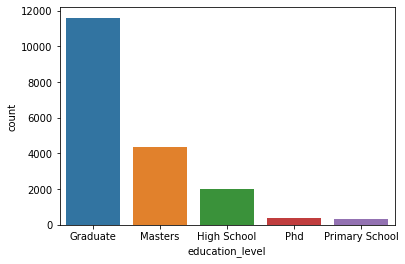

In [11]:
sns.countplot(x='education_level', data=df)

In [12]:
# cols=df.drop(columns='target')
# for c in cols.columns:
#     sns.barplot(x=df[c], y=df['target'])
#     plt.show()

In [13]:
#sns.pairplot(df)

In [14]:
df['target'].value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

#### Uh oh looks like we have a little class imbalance.

# Split up our data

In [15]:
X=df.drop(columns='target')
y=df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=22, stratify=y)

In [16]:
df.columns

Index(['city', 'city_development_index', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

In [17]:
num_cols=['city_development_index', 'training_hours']
cat_cols=['city', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',]

In [18]:
preprocessing = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
        ("encode", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

# I'm going to run a few different models.

## We'll do an XGB Classifcation model first

We need to make sure to address the class imbalance

In [22]:
n_estimators = 100
learning_rate = 2 / n_estimators

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('sampling', SMOTE()),
    ('model', XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate)),
])

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

grid = {
    "model__subsample": [0.5, 0.75, 1.0],
    "model__colsample_bytree": [0.5, 0.75, 1.0],
    "model__max_depth": [7, 10, 12],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=5, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  2.5min finished
c:\users\matth\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['city_development_index',
                                                                          'training_hours']),
                                                                        ('encode',
                                                                         LeaveOneOutEncoder(),
                                                                         ['city',
                                                                          'relevent_experience',
                                                                          'enrolled_university',
                    

In [23]:
print(f"Train score: {pipeline_cv.score(X_train, y_train)}")
print(f"Test score: {pipeline_cv.score(X_test, y_test)}")

Train score: 0.6633172386793684
Test score: 0.6636221294363257


In [24]:
pipeline_cv.best_params_

{'model__colsample_bytree': 0.75,
 'model__max_depth': 12,
 'model__subsample': 0.5}

In [64]:
y_pred = pipeline_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_Not_Looking_for_job", "actual_Looking_for_job"],
    columns=["pred_Not_Looking_for_job", "pred_Looking_for_job"],
)
print(f'percentage matrix{confusion_mat/(len(y_pred))}')
display(confusion_df)

[[2462  415]
 [ 874   81]]
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.79      2877
         1.0       0.16      0.08      0.11       955

    accuracy                           0.66      3832
   macro avg       0.45      0.47      0.45      3832
weighted avg       0.59      0.66      0.62      3832

percentage matrix[[0.64248434 0.10829854]
 [0.22807933 0.02113779]]


,pred_Not_Looking_for_job,pred_Looking_for_job
actual_Not_Looking_for_job,2462,415
actual_Looking_for_job,874,81


Didn't get a very good accuracy. Even on the training data the model was getting accuracy equivalent to just guessing 0 everytime. We know by the confusion matrix, that it did not. 

We would need to decide which is more costly: training an employee who immediately leaves the company after the training or not investing to educate a current employee because you expect him to leaving the company soon.

## Let's check a Random Forest classifier. 

In [26]:
n_estimators = 100
learning_rate = 2 / n_estimators

pipeline_rf = Pipeline([
    ('preprocessing', preprocessing),
    ('sampling', SMOTE()),
    ('RFmodel', RandomForestClassifier()),
])


pipeline_rf.fit(X_train, y_train)

train_score = pipeline_rf.score(X_train, y_train)
test_score = pipeline_rf.score(X_test, y_test)

print(f"Train score for Linear Regression model before gridsearch: {train_score}")
print(f"Test score for Linear Regression model before gridsearch: {test_score}")


grid = {
    "RFmodel__n_estimators": [50, 100, 150],
    'RFmodel__max_depth': [80, 90, 100, 110],
    'RFmodel__min_samples_leaf': [3, 4, 5],
}

pipeline_rf_cv = GridSearchCV(pipeline_rf, grid, verbose=1, cv=5, n_jobs=-1)
pipeline_rf_cv.fit(X_train, y_train)

print(f"Train score for Linear Regression model: {pipeline_rf_cv.score(X_train, y_train)}")
print(f"Test score for Linear Regression model: {pipeline_rf_cv.score(X_test, y_test)}")

Train score for Linear Regression model before gridsearch: 0.7507503588672844
Test score for Linear Regression model before gridsearch: 0.7510438413361169
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.3min finished


Train score for Linear Regression model: 0.7506851102701292
Test score for Linear Regression model: 0.7507828810020877


In [63]:
print(pipeline_rf_cv.best_params_)

y_pred = pipeline_rf_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_Not_Looking_for_job", "actual_Looking_for_job"],
    columns=["pred_Not_Looking_for_job", "pred_Looking_for_job"],
)
print(f'percentage matrix{confusion_mat/(len(y_pred))}')

display(confusion_df)

{'RFmodel__max_depth': 100, 'RFmodel__min_samples_leaf': 4, 'RFmodel__n_estimators': 150}
[[2877    0]
 [ 955    0]]
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      2877
         1.0       0.00      0.00      0.00       955

    accuracy                           0.75      3832
   macro avg       0.38      0.50      0.43      3832
weighted avg       0.56      0.75      0.64      3832

percentage matrix[[0.75078288 0.        ]
 [0.24921712 0.        ]]


c:\users\matth\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,pred_Not_Looking_for_job,pred_Looking_for_job
actual_Not_Looking_for_job,2877,0
actual_Looking_for_job,955,0


In [62]:
pipeline_rf_cv.best_estimator_["RFmodel"].feature_importances_


array([8.51880225e-03, 1.37339933e-04, 1.54950657e-02, 2.24615764e-01,
       1.44514655e-01, 1.80315266e-01, 3.03422215e-01, 1.51585851e-03,
       5.17118259e-02, 6.31981532e-02, 6.55505458e-03])

This model just predicted that the employee would stay everytime. This is not good.

## Let's try KNN model

In [32]:
pipeline_knn = Pipeline([
    ('preprocessing', preprocessing),
    ('sampling', SMOTE()),
    ('KNmodel', KNeighborsClassifier()),
])


pipeline_knn.fit(X_train, y_train)

train_score = pipeline_knn.score(X_train, y_train)
test_score = pipeline_knn.score(X_test, y_test)

print(f"Train score for Linear Regression model before gridsearch: {train_score}")
print(f"Test score for Linear Regression model before gridsearch: {test_score}")


grid = {
    "KNmodel__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "KNmodel__n_neighbors": [5, 10, 25, 50]
}

pipeline_knn_cv = GridSearchCV(pipeline_knn, grid, verbose=1, cv=5, n_jobs=-1)
pipeline_knn_cv.fit(X_train, y_train)

print(f"Train score for Linear Regression model: {pipeline_knn_cv.score(X_train, y_train)}")
print(f"Test score for Linear Regression model: {pipeline_knn_cv.score(X_test, y_test)}")

Train score for Linear Regression model before gridsearch: 0.8149549784679629
Test score for Linear Regression model before gridsearch: 0.6970250521920668
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished


Train score for Linear Regression model: 0.7462482056635782
Test score for Linear Regression model: 0.7445198329853863


In [65]:
print(pipeline_knn_cv.best_params_)

y_pred = pipeline_knn_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_Not_Looking_for_job", "actual_Looking_for_job"],
    columns=["pred_Not_Looking_for_job", "pred_Looking_for_job"],
)
print(f'percentage matrix{confusion_mat/(len(y_pred))}')
display(confusion_df)

{'KNmodel__algorithm': 'auto', 'KNmodel__n_neighbors': 50}
[[2106  771]
 [ 208  747]]
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      2877
         1.0       0.49      0.78      0.60       955

    accuracy                           0.74      3832
   macro avg       0.70      0.76      0.71      3832
weighted avg       0.81      0.74      0.76      3832

percentage matrix[[0.54958246 0.20120042]
 [0.05427975 0.19493737]]


,pred_Not_Looking_for_job,pred_Looking_for_job
actual_Not_Looking_for_job,2106,771
actual_Looking_for_job,208,747


KNN model is over fit. The model also did not have a very good performance. It does slightly worse than just guessing the majority class every time. This model does an okay job in correctly predicting if an employee is not looking to change jobs. It guesses the 

## Let's try a logistic regression classifier.

In [34]:
pipeline_lg = Pipeline([
    ('preprocessing', preprocessing),
    ('sampling', SMOTE()),
    ('LRmodel', LogisticRegression(max_iter=1000)),
])


pipeline_lg.fit(X_train, y_train)

train_score = pipeline_lg.score(X_train, y_train)
test_score = pipeline_lg.score(X_test, y_test)

print(f"Train score for Linear Regression model before gridsearch: {train_score}")
print(f"Test score for Linear Regression model before gridsearch: {test_score}")


grid = {
    "LRmodel__C": [0.1, 0.25, .5, 0.75, 1.0],
    "LRmodel__penalty": ['l1', 'l2', 'elasticnet', 'none']
}

pipeline_lg_cv = GridSearchCV(pipeline_lg, grid, verbose=1, cv=5, n_jobs=-1)
pipeline_lg_cv.fit(X_train, y_train)

print(f"Train score for Linear Regression model: {pipeline_lg_cv.score(X_train, y_train)}")
print(f"Test score for Linear Regression model: {pipeline_lg_cv.score(X_test, y_test)}")

Train score for Linear Regression model before gridsearch: 0.7684979772934882
Test score for Linear Regression model before gridsearch: 0.7630480167014614
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.4s finished


Train score for Linear Regression model: 0.7690199660707295
Test score for Linear Regression model: 0.7620041753653445


So it looks like we get a slightly better score with Logistic Regression classifier.

Let's looks at the best parameters

In [35]:
pipeline_lg_cv.best_params_

{'LRmodel__C': 1.0, 'LRmodel__penalty': 'none'}

Let's look at the Logistic classifier confusion matrix

In [66]:
print(pipeline_lg_cv.best_params_)

y_pred = pipeline_lg_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_Not_Looking_for_job", "actual_Looking_for_job"],
    columns=["pred_Not_Looking_for_job", "pred_Looking_for_job"],
)

print(f'percentage matrix{confusion_mat/(len(y_pred))}')
display(confusion_df)

{'LRmodel__C': 1.0, 'LRmodel__penalty': 'none'}
[[2193  684]
 [ 228  727]]
              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      2877
         1.0       0.52      0.76      0.61       955

    accuracy                           0.76      3832
   macro avg       0.71      0.76      0.72      3832
weighted avg       0.81      0.76      0.77      3832

percentage matrix[[0.57228601 0.17849687]
 [0.05949896 0.18971816]]


,pred_Not_Looking_for_job,pred_Looking_for_job
actual_Not_Looking_for_job,2193,684
actual_Looking_for_job,228,727
